In [2]:
import pennylane as qml
import pennylane.numpy as np
import numpy as illegal_but_typed_np
from numpy.typing import NDArray

## 1. Set up circuit to optimize

In [3]:
from circuits import sim_03

num_layers = 5
num_qubits = 4
circuit = sim_03(num_layers, num_qubits)
initial_params = (
    np.array(np.random.random((num_layers, num_qubits, 2))),
    np.array(np.random.random((num_layers, num_qubits - 1)))
)
print(qml.draw(circuit)(*initial_params))

# demo circuit from Rotosolve docs, crotosolve cannot solve this
# dev = qml.device('default.qubit', wires=3, shots=None)
# @qml.qnode(dev)
# def circuit(rot_param: NDArray, layer_param: float, crot_param: NDArray):
#     for i, par in enumerate(rot_param):
#         qml.RX(par, wires=i)
#     for w in dev.wires:
#         qml.RX(layer_param, wires=w)
#     for i, par in enumerate(crot_param):
#         qml.CRY(par, wires=[i, (i+1) % 3])
#     return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))
# params = (
#     np.array([0.3, 0.2, 0.67], requires_grad=True),
#     np.array(1.1, requires_grad=True),
#     np.array([-0.2, 0.1, -2.5], requires_grad=True)
# )

0: ──RX(0.26)──RZ(0.42)─────────────────────╭RZ(0.14)──||──RX(0.67)──RZ(0.16)────────────────────
1: ──RX(0.65)──RZ(0.08)───────────╭RZ(0.19)─╰●─────────||──RX(0.47)──RZ(0.50)───────────╭RZ(0.89)
2: ──RX(0.94)──RZ(0.55)─╭RZ(0.24)─╰●───────────────────||──RX(0.12)──RZ(0.50)─╭RZ(0.53)─╰●───────
3: ──RX(0.82)──RZ(0.44)─╰●─────────────────────────────||──RX(0.78)──RZ(0.46)─╰●─────────────────

──╭RZ(0.07)──||──RX(0.91)──RZ(0.50)─────────────────────╭RZ(0.13)──||──RX(0.75)──RZ(0.14)──────────
──╰●─────────||──RX(0.11)──RZ(0.09)───────────╭RZ(0.26)─╰●─────────||──RX(0.98)──RZ(0.50)──────────
─────────────||──RX(0.85)──RZ(0.38)─╭RZ(0.75)─╰●───────────────────||──RX(0.75)──RZ(0.16)─╭RZ(0.38)
─────────────||──RX(0.94)──RZ(0.67)─╰●─────────────────────────────||──RX(0.50)──RZ(0.39)─╰●───────

────────────╭RZ(0.80)──||──RX(0.39)──RZ(0.43)─────────────────────╭RZ(0.33)──||─┤     
──╭RZ(0.04)─╰●─────────||──RX(0.80)──RZ(0.98)───────────╭RZ(0.33)─╰●─────────||─┤  <Z>
──╰●───────────────────||──RX(0.

## 2. Run `Crotosolve` optimization

In [4]:
from CrotosolveOptimizer import CrotosolveOptimizer

# optimizer = qml.AdamOptimizer()

max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = CrotosolveOptimizer()

#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
params = initial_params
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker:
    params, prev_cost, sub_cost = optimizer.step_and_cost(
        circuit,
        *params,
        full_output=True
    )

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 6 * (cost_idx + 1), # TODO: reduce once special treatment for RP gates is applied
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])
    print(cost)

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 6 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])
    print(cost)

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

crotosolve_cost = cost

[(0, -0.12951982536504736), (6, -0.4148032066476966), (12, -0.5134078580321435), (18, -0.535567465887241), (24, -0.7193041016142321), (30, -0.8338893590086127), (36, -0.8386942297294312), (42, -0.8388759260308909), (48, -0.8388927216161305), (54, -0.8390913842364487), (60, -0.8390915718431236), (66, -0.9557128095080575), (72, -0.9952835714259138), (78, -0.9960880988565777), (84, -0.9967304045232318), (90, -0.9970124136971372), (96, -0.9970359065019645), (102, -0.9971948642231434), (108, -0.997469228442411), (114, -0.9990422776872436), (120, -0.999043220284397), (126, -0.9995587613508279), (132, -0.9995662148649497), (138, -0.9995689238190574), (144, -0.9995689238190568), (150, -0.9997637861844096), (156, -0.9997637861844099), (162, -0.9997676580567723), (168, -0.9998654466402281), (174, -0.9999196145971875), (180, -0.9999196145971875), (186, -0.9999196145971878), (192, -0.9999196145971875), (198, -0.9999196145971877), (204, -0.9999196145971879), (210, -0.9999201668403475), (216, -0.999

## 3. Run `Rotosolve` optimization

In [5]:
max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = qml.RotosolveOptimizer()
params = initial_params

spectrum_fn = qml.fourier.qnode_spectrum(circuit)
spectra = spectrum_fn(*params)
#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker: -> 2 per param shift rule appl.
    params, prev_cost, sub_cost = optimizer.step_and_cost(
        circuit,
        *params,
        spectra=spectra,
        full_output=True
    )

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 2 * (cost_idx + 1) + 1,
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])
    print(cost)

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 6 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])
    print(cost)

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

rotosolve_cost = cost

[(0, -0.12951982536504736), (3, -0.41480320664771086), (5, -0.51340788047603), (7, -0.535567480957793), (9, -0.7193042206173648), (11, -0.8338894988008161), (13, -0.8386943722223245), (15, -0.8388760674862125), (17, -0.8388928629965873), (19, -0.8390915231912492), (21, -0.839091710870275), (23, -0.9557128596280207), (25, -0.9952835624029741), (27, -0.9960880890727049), (29, -0.9967303962433594), (31, -0.9970124065243772), (33, -0.9970358993551705), (35, -0.9971948580042531), (37, -0.9974692207197936), (39, -0.9990422810600251), (41, -0.9990432235411317), (43, -0.9995587607652904), (45, -0.9995662143086107), (47, -0.9995689231622444), (49, -0.9995689231622451), (51, -0.9997637856334778), (53, -0.9997637856334786), (55, -0.9997676571550332), (57, -0.9998654461840428), (59, -0.999919614734505), (61, -0.9999196147345059), (63, -0.9999196147345044), (65, -0.9999196147345049), (67, -0.9999196147345049), (69, -0.9999196147345051), (71, -0.9999201666255304), (73, -0.9999201666255307), (75, -0.

## 4. Run `GradientDescent` optimization

In [14]:
max_iterations = 500
convergence_threshold = 1e-06

optimizer = qml.GradientDescentOptimizer()
params = initial_params

#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker: # TODO: this does not work as expected, should return  >=2 executions per param shift rule appl.
    params, prev_cost = optimizer.step_and_cost(
        circuit,
        *params,
    )
    evaluations_here = 2
    current_cost = float(circuit(*params))

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.append((evaluations_so_far + evaluations_here, current_cost))
    print(cost)

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

gradientdescent_cost = cost

[(0, -0.12951982536504736), (2, -0.15667563322518646)]
[(0, -0.12951982536504736), (2, -0.15667563322518646), (4, -0.18358850492481865)]
[(0, -0.12951982536504736), (2, -0.15667563322518646), (4, -0.18358850492481865), (6, -0.2102085879119423)]
[(0, -0.12951982536504736), (2, -0.15667563322518646), (4, -0.18358850492481865), (6, -0.2102085879119423), (8, -0.2364885127264731)]
[(0, -0.12951982536504736), (2, -0.15667563322518646), (4, -0.18358850492481865), (6, -0.2102085879119423), (8, -0.2364885127264731), (10, -0.2623836912800742)]
[(0, -0.12951982536504736), (2, -0.15667563322518646), (4, -0.18358850492481865), (6, -0.2102085879119423), (8, -0.2364885127264731), (10, -0.2623836912800742), (12, -0.28785257009669785)]
[(0, -0.12951982536504736), (2, -0.15667563322518646), (4, -0.18358850492481865), (6, -0.2102085879119423), (8, -0.2364885127264731), (10, -0.2623836912800742), (12, -0.28785257009669785), (14, -0.3128568367296367)]
[(0, -0.12951982536504736), (2, -0.15667563322518646), 

## N. Plot loss curve

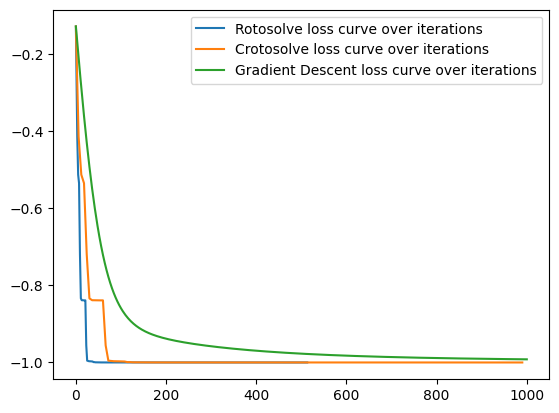

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# ax.plot(range(len(iterations_dataset)), iterations_dataset, 'b')
# ax.set_title("Loss curve over iterations")

plot_data = [
    ("Rotosolve", rotosolve_cost),
    ("Crotosolve", crotosolve_cost),
    ("Gradient Descent", gradientdescent_cost)
]

for optimizer_name, loss_curve_data in plot_data:
    x, y = zip(*loss_curve_data) # this unzips the list of points

    ax.plot(x, y, label=f"{optimizer_name} loss curve over iterations")
    ax.legend()